# 0. Setup

In [1]:
# libraries

import matplotlib.pyplot as plt
import pandas as pd
import os
import numpy as np
from PIL import Image as PilImage
from typing import Tuple
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Lambda, Conv2D, BatchNormalization, MaxPooling2D, Dense, Flatten, Dropout, Activation
from tensorflow.keras.regularizers import L2

# working directories
WORKDIR = os.path.abspath('D:\\Users\\nbakotic\\iccecme-dataset') # get the path of this file - image metadata
IMAGESDIR = os.path.join(WORKDIR, 'imagespng') # get the path of image folder

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [51]:
def plot_diff(y_true, y_pred, title=''):
    plt.scatter(y_true, y_pred)
    plt.title(title)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim(plt.xlim())
    plt.ylim(plt.ylim())
    plt.show()


def plot_metrics(history, metric_name, title):
    plt.title(title)
    plt.plot(history.history[metric_name], color='blue', label=metric_name)
    plt.plot(history.history['val_' + metric_name], color='green', label='val_' + metric_name)
    plt.show()
    
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# 1.1 - Load and Process Metadata

0. Load data.
1. Drop columns other than WindowCenter and WindowWidth. In this experiment, the goal is to see how well the model can predict these values from images alone. Another model will be built later to see impact of remaining features on predictions.
2. Some values for WindowCenter and WindowWidth contain more than one number. In those cases, the first value will be used for learning, like in "Using Autoencoders to Reduce Dimensionality of DICOM Metadata".
3. Convert string values to float32.

In [2]:
# 0. read metadata
df = pd.read_csv(os.path.join(WORKDIR, 'metadata.csv'), index_col='id')
df = df.drop(columns=['WindowCenter' ,'WindowWidth', 'Rows', 'Columns', 'StudyDescription'])
df = df.fillna(value='UNKNOWN')

bit_depth = df['HighBit']

mod_dummies = pd.get_dummies(df.Modality)
bpe_dummies = pd.get_dummies(df.BodyPartExamined)
hbit_dummies = pd.get_dummies(df.HighBit)
df = pd.concat([df, hbit_dummies, mod_dummies, bpe_dummies], axis='columns')
df = df.drop(columns=['Modality' ,'BodyPartExamined', 'HighBit', 7, 'XA','UNKNOWN'])
#df = pd.concat([metadata_df, df], axis='columns')


# 0. read metadata
metadata_df = pd.read_csv(os.path.join(WORKDIR, 'metadata.csv'), index_col='id')
metadata_df = metadata_df.drop(columns=['Modality', 'Rows', 'Columns', 'BodyPartExamined', 'HighBit', 'StudyDescription'])

# 2. format numbers
# find cells that contain two instead of one number and return only the first number
def extract_number_from_list(val):
    if ',' in val:
        idx = val.find(',')
        return val[1:idx]
    else:
        return val
    
metadata_df = metadata_df.applymap(extract_number_from_list)

# 3. convert string values to float
metadata_df['WindowCenter'] = metadata_df['WindowCenter'].astype('float32')
metadata_df['WindowWidth'] = metadata_df['WindowWidth'].astype('float32')

labels_df = metadata_df.copy()
labels_df['WindowCenter'] = np.maximum(np.array(metadata_df['WindowCenter']), 0) / np.array(metadata_df['WindowCenter']).max() * 255.0
labels_df['WindowWidth'] = np.maximum(np.array(metadata_df['WindowWidth']), 0) / np.array(metadata_df['WindowWidth']).max() * 255.0

# 1.2 Load and Process Images
0. Read images from folder. Because of .npy format, they are ready into a list and converted to ndarray.
1. Add padding to images so they are all the same size. Most images are around 512 x 512 px so those dimensions are used.
2. Some images contain values below 0, but as they show as black, they are converted to 0.
3. Grayscale images have one color channel, but this dimension is dropped by default in the array so it has to be added back.
4. Normalize the data. Since images range from 8-bit to 16-bit, the values are divided by 2^16 - 1.

In [164]:
#from radiologynet.tools.visualization.image import is_image_multidimensional
#from radiologynet.logging import log

def save_image_slice(
    pixel_array: np.ndarray,
    fullpath: str,
    bits: int = 8,
    size: Tuple[int, int] = (None, None),
    verbose: bool = False,
):
    """Save a 2D image to disk.

    Args:
        pixel_array (np.ndarray): Pixel Array containing the image.

        fullpath (str): Full path to the new image (the full location
            where image should be saved). This should include the image
            name and extension.
        bits (int, optional): How many bits should the output image have.
            Defaults to 8.
        size (Tuple[int, int], optional): height and width of the
            new image, respectively.
            Defaults to (None, None).
        verbose (bool, optional): If True, prints out useful logs.
            Defaults to False.

    Raises:
        AssertionError: if the image provided is multidimensional.
    """
    image = pixel_array

    #if (bits > 8):
    #    image = image.astype(np.uint16)
    #else:
    #    image = image.astype(np.uint8)
    image = image.astype(np.uint8)

    image_to_save = resize_image(image, size, verbose=verbose, resample=PilImage.BILINEAR, zero_padding=True)

    head, tail = os.path.split(fullpath)
    os.makedirs(head, exist_ok=True)
    image_to_save.save(fullpath)
    return

def save_image_as_png(
    dcm_id: int,
    pixel_array: np.ndarray,
    folder_where_to_save: str = './',
    verbose: bool = False,
    size: Tuple[int, int] = (None, None),
    exist_ok=False,
    bits: int = 8,
):
    """Save an entire image as a single or multiple PNGs.

    If image is  multidimensional, it will be saved as multiple PNGs.

    Args:
        dcm_id (int): ID of the DICOM image. Used for nomenclature and
            saving images named as their IDs.
        pixel_array (np.ndarray): The image itself.
        folder_where_to_save (str, optional): Where to save the images.
            Defaults to './'.
        verbose (bool, optional): Whether to print out useful logs.
            Defaults to False.
        size (Tuple[int, int], optional): Height and width of the image
            respectively; the original image will be resized to
            these dimensions.
            If not provided, the image will not be resized.
            Defaults to (None, None).
        exist_ok (bool, optional): If False and the exported image exists,
            a new image will not be created. If True, the existing image
            will be overriden. If the image does not exist, this is ignored.
            Defaults to False.
        bits (int, optional): How many bits should the output image have.
            Defaults to 8.
    """
    #subfolder = str(dcm_id)[0:-3]

    fullpath = os.path.join(folder_where_to_save, f'{dcm_id}.png')
    if (exist_ok is False and os.path.isfile(fullpath)):
        log(f'Found {fullpath}, skipping DCM ID: {dcm_id}', verbose=verbose)
    else:
        os.makedirs(folder_where_to_save, exist_ok=True)
        save_image_slice(
            pixel_array,
            fullpath,
            bits=bits,
            verbose=verbose,
            size=size,
            )
        
def resize_image(
    image: np.ndarray,
    size: Tuple[int, int],
    verbose: bool = False,
    resample=PilImage.NEAREST,
    zero_padding: bool = False
):
    """Resize an image.

    This will resize the image to the specified size,
    and will add zero padding where necessary. The aspect ratio is always preserved.

    Args:
        image (np.ndarray): The image to resize, in a numpy array.

        size (Tuple[int, int]): The size of the output image.
            The first parameter is the output height, the second is the output width.
            One of these parameter can be None (either height or width), if both
            height and width are None, then an `AssertionError` is thrown.
            The size will be parsed according to the following options:
            - if height is None, then image will be scaled to fit the specified width.
            The height will be calculated automatically to preserve aspect ratio.
            - if width is None, the same thing applies as when height is missing.
            - if both height and width are set, then these will be considered
            the 'maximal' output size. If `zero_padding` is True, then the output image
            will have the same size as specified here, with padding added where it's needed.
            If `zero_padding` is False, then the output image size may vary,
            and it will scale so that the entire image *is not bigger than* this size.
            Aspect ratio is always preserved.

        verbose (bool, optional): Print useful logs. Defaults to False.

        resample (_type_, optional): Pillow image resampling option.
            Defaults to PilImage.NEAREST.

        zero_padding (bool, optional): Whether to add zero-padding.
            Used only if both height and width are set.
            Defaults to False.

    Returns:
        Pillow Image: The resized image, as an instance of Pillow.Image.
    """
    resized_image = PilImage.fromarray(image)
    curh, curw = image.shape
    aspect = curh / curw

    # make sure at least one of the sizes is provided
    assert size[0] is not None or size[1] is not None, 'At least one dimension size must be specified!'

    # convert to list so we can index the values
    # and change them if necessary
    # because tuple objects are immutable
    size = list(size)

    newh, neww = size
    if (size[0] is None):
        # if height not provided
        # calculate height from width in a way that preserves aspect ratio
        size[0] = round(size[1] * aspect)
        newh = size[0]
    elif (size[1] is None):
        # apply the same process for width
        size[1] = round(size[0] / aspect)
        neww = size[1]
    else:
        # both sizes are not None
        # this means that //maybe// we will have to add
        # zero padding later on
        # and it means that size[0] and size[1] are not
        # set in a way that preserves aspect ratio
        # so we'll just set new width and new height
        # in a way that preserves aspect an then later
        # add padding if necessary
        neww = min(size[1], curw / (curh / size[0]))
        neww = round(neww)
        newh = round(neww * aspect)
        # newh =
        # neww = round(curw / (curh / size[0]))
        # if (curh > curw):
        #     # neww = round(size[1] / aspect)
        #     # neww = round( (size[1] / aspect)))
        # else:

    # resize the core image
    resized_image = resized_image.resize((neww, newh), resample=resample)

    if (zero_padding is True):
        # once resized, now we have to (optionally) add zero-padding
        # first, calc the amount of padding which should be added
        # (padding is added by setting the top-left point where the image is
        # pasted onto an image of zeros)
        # note that, e.g., if size[1] is equal to new width, no padding will be added!
        pad_left = int((size[1] - neww) // 2)
        pad_top = int((size[0] - newh) // 2)

        # now let's make a new image which consists of zeros only
        # (which means color is 0)
        result = PilImage.new(resized_image.mode, (size[1], size[0]), color=0)
        # now we have an all-zero image. We should paste the resized image
        # in the middle of it
        result.paste(resized_image, (pad_left, pad_top))

        resized_image = result

    return resized_image


In [165]:
# Only run this once to create a folder of pngs

'''
def read_file(file_name):
    imagepath = os.path.join('D:\\Users\\nbakotic\\iccecme-dataset\\images', f'{file_name}.npy')
    with open(imagepath, 'rb') as file:
        img = np.load(file)
    return img

for i in range(len(metadata_df)):
    img = read_file(metadata_df.index[i])
    scaled_image = (np.maximum(img, 0) / img.max()) * 255.0
    save_image_as_png(metadata_df.index[i], scaled_image, 'D:\\Users\\nbakotic\\iccecme-dataset\\imagespng', False, (128, 128), True)
'''

c:\Users\nbakotic\.conda\envs\icecme\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


In [ ]:
def read_file(file_name):
    imagepath = os.path.join('D:\\Users\\nbakotic\\iccecme-dataset\\images', f'{file_name}.npy')
    with open(imagepath, 'rb') as file:
        img = np.load(file)
    return img

image = read_file('4336820')

plt.imshow(image, cmap='gray')

print(str(np.min(image)) + ' ' + str(np.max(image)))

# 2. Create Datasets
Because the dataset is large, it is not possible to put all of it at once in the GPU memory. Creating a dataset using 'tf.data.Dataset.from_tensor_slices' is also not possible, therefore a custom DataGenerator class is used.

1. Create train-validation-test datasets.

In [3]:
def normalize_tensor(tensor):
    max = np.max(tensor)
    min = np.min(tensor)
    return (tensor - min) / (max - min)

In [62]:
img_means = np.mean(X)
img_std_devs = np.std(X)

def image_scaler(images):
    return (images - img_means) / img_std_devs

# format datasets - return tuple
def format_output(data):
    window_center = data.pop('WindowCenter')
    window_center = np.array(window_center)
    window_width = data.pop('WindowWidth')
    window_width = np.array(window_width)
    return window_center, window_width

# 1. create train-validation-test dataset splits
# choose train, validation and test rations
train_ratio = 0.72
validation_ratio = 0.08
test_ratio = 0.20

# train - test split
x_train, x_test, y_train, y_test = train_test_split(image_scaler(X), labels_df, test_size=1-train_ratio)

# test - validation split,validation is treated as train data
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio))

# format outputs for each split
y_train = format_output(y_train)
y_val = format_output(y_val)
y_test = format_output(y_test)

In [79]:
from PIL import Image
def get_image(df):
    x_img = []

    for id in df.index:
        
        img = np.array(Image.open(os.path.join(IMAGESDIR, str(id) + '.png')).convert('L'))

        img = np.expand_dims(img, -1)
        x_img.append(img)

    x_img = np.array(x_img)

    return x_img

X = get_image(df)
img_means = np.mean(X)
img_std_devs = np.std(X)

def image_scaler(images):
    return (images - img_means) / img_std_devs


# format datasets - return tuple
def format_output(data):
    window_center = data.pop('WindowCenter')
    window_center = np.array(window_center)
    window_width = data.pop('WindowWidth')
    window_width = np.array(window_width)
    return window_center, window_width

# 1. create train-validation-test dataset splits
# choose train, validation and test rations
train_ratio = 0.72
validation_ratio = 0.08
test_ratio = 0.20

# train - test split
x_train, x_test, y_train, y_test = train_test_split(df, labels_df, test_size=1-train_ratio)

# test - validation split,validation is treated as train data
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio))

# format outputs for each split
y_train = format_output(y_train)
y_val = format_output(y_val)
y_test = format_output(y_test)

x_train_img = get_image(x_train)
x_val_img = get_image(x_val)
x_test_img = get_image(x_test)

def format_metadata(data):
    highbit = data[[9, 11, 15]]
    modalities = data[['CT', 'CR', 'MR', 'NM', 'RF']] 
    bpe = data.drop(columns=[9, 11, 15, 'CT', 'CR', 'MR', 'NM', 'RF'])

    return np.array(highbit), np.array(modalities), np.array(bpe)

#x_train_hbit, x_train_mod, x_train_bpe = format_metadata(x_train)
#x_val_hbit, x_val_mod, x_val_bpe = format_metadata(x_val)
#x_test_hbit, x_test_mod, x_test_bpe = format_metadata(x_test)

x_train_metadata = np.array(x_train)
x_val_metadata = np.array(x_val)
x_test_metadata = np.array(x_test)

# MULTI OUTPUT MODEL

In [7]:
def model_builder(hp):
    losses = {
        "window_center": keras.losses.MeanSquaredError(),
        "window_width": keras.losses.MeanSquaredError(),
    }

    metrics = {
        "window_center": tf.keras.metrics.MeanSquaredError(),
        "window_width": tf.keras.metrics.MeanSquaredError()
    }
    

    hp_layer_1 = hp.Choice('layer_1', values=[8, 16, 32])
    hp_layer_2 = hp.Choice('layer_2', values=[32, 64, 128])
    hp_layer_3 = hp.Choice('layer_3', values=[128, 256, 512])
    #hp_layer_4 = hp.Choice('layer_4', values= [16, 32, 64, 128])
    #hp_layer_5 = hp.Choice('layer_5', values= [16, 32, 64, 128])

    hp_dense = hp.Choice('dense_1', values=['32', '64', '128', '256'])

    hp_regularizer = hp.Choice('regularization_factor', values=[0.0, 0.001, 0.01, 0.1])
    hp_optimizer = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    inputs = Input(shape=(128, 128,1))

    x = Conv2D(filters=hp_layer_1, kernel_size=3, kernel_regularizer=L2(hp_regularizer), activation='relu') (inputs)
    x = MaxPooling2D() (x) 
    x = Conv2D(filters=hp_layer_2, kernel_size=3, kernel_regularizer=L2(hp_regularizer), activation='relu') (x)
    x = MaxPooling2D() (x)
    x = Conv2D(filters=hp_layer_2,kernel_size=3, kernel_regularizer=L2(hp_regularizer), activation='relu') (x)
    x = MaxPooling2D() (x)
    x = Conv2D(filters=hp_layer_3, kernel_size=3, kernel_regularizer=L2(hp_regularizer), activation='relu') (x)
    x = MaxPooling2D() (x)
    x = Conv2D(filters=hp_layer_3, kernel_size=3, kernel_regularizer=L2(hp_regularizer), activation='relu') (x)
    x = MaxPooling2D() (x)


    '''
    y = Conv2D(filters=hp_layer_1, kernel_size=3, kernel_regularizer=L2(hp_regularizer), activation='relu') (inputs)
    y = MaxPooling2D() (y) 
    y = Conv2D(filters=hp_layer_2, kernel_size=3, kernel_regularizer=L2(hp_regularizer), activation='relu') (y)
    y = MaxPooling2D() (y)
    y = Conv2D(filters=hp_layer_2, kernel_size=3, kernel_regularizer=L2(hp_regularizer), activation='relu') (y)
    y = MaxPooling2D() (y)
    y = Conv2D(filters=hp_layer_3, kernel_size=3, kernel_regularizer=L2(hp_regularizer), activation='relu') (y)
    y = MaxPooling2D() (y)
    y = Conv2D(filters=hp_layer_3, kernel_size=3, kernel_regularizer=L2(hp_regularizer), activation='relu') (y)
    y = MaxPooling2D() (y)
    '''


    x = Flatten() (x)
    #y = Flatten() (y)

    x = Dense(units=hp_dense, activation='relu', kernel_regularizer=L2(hp_regularizer)) (x)
    y = Dense(units=hp_dense, activation='relu', kernel_regularizer=L2(hp_regularizer)) (x)  

    output1 = Dense(units='1', activation='linear', name="window_center")(x)
    output2 = Dense(units='1', activation='linear', name="window_width")(x)

    model = Model(inputs=inputs, outputs=[output1, output2])
    
    optim = keras.optimizers.Adam(learning_rate=hp_optimizer)

    model.compile(optimizer=optim, loss=losses, metrics=metrics)
    
    return model


import keras_tuner as kt

tuner = kt.Hyperband(model_builder,
                        objective='val_loss',
                        max_epochs=50,
                        factor=3,
                        directory='dir',
                        project_name='icecme'
                        )


stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

tuner.search(image_scaler(x_train_img), y_train, epochs=50, batch_size=256, validation_data=(image_scaler(x_val_img), y_val), callbacks=[stop_early], verbose=2)

best_hyperparams = tuner.get_best_hyperparameters(num_trials=1)[0]

model_hp = tuner.hypermodel.build(best_hyperparams)

history_hp = model_hp.fit(image_scaler(x_train_img), y_train, epochs=50, batch_size=256, validation_data=(image_scaler(x_val_img), y_val), callbacks=[stop_early], verbose=2)

predictions_hp = model_hp.predict(image_scaler(x_test_img))
center_pred = predictions_hp[0]
width_pred = predictions_hp[1]

test_center = y_test[0]
test_width = y_test[1]

# Difference between true and predicted values
plot_diff(test_center, center_pred, title='CENTER')
plot_diff(test_width, width_pred, title='WIDTH')

# Plot MSE
plot_metrics(history_hp, metric_name='window_center_mean_squared_error', title='WINDOW CENTER MSE')
plot_metrics(history_hp, metric_name='window_width_mean_squared_error', title='WINDOW WIDTH MSE')

# NORMAL

In [85]:
regularization_factor = 0.01  #0.01

image_size = 128

layer_1 = 32  #32
layer_2 = 64  #64
layer_3 = 128 #128
layer_4 = 128 #128   #256
layer_5 = 256 #256

dense = '64' #54


def build_mo_model():
    inputs = Input(shape=(image_size, image_size, 1))
    
    x = Conv2D(layer_1, 3, kernel_regularizer=L2(regularization_factor), activation='relu') (inputs)
    x = MaxPooling2D() (x)  

    x = Conv2D(layer_2, 3, kernel_regularizer=L2(regularization_factor), activation='relu') (x)
    x = MaxPooling2D() (x)    
    
    x = Conv2D(layer_3, 3, kernel_regularizer=L2(regularization_factor), activation='relu') (x)
    x = MaxPooling2D() (x)
    
    x = Conv2D(layer_4, 3, kernel_regularizer=L2(regularization_factor), activation='relu') (x)
    x = MaxPooling2D() (x)
    
    x = Conv2D(layer_5, 3, kernel_regularizer=L2(regularization_factor), activation='relu') (x)
    x = MaxPooling2D() (x) 
    
    
    x = Flatten() (x) 

    x = Dense(units=dense, activation='relu', kernel_regularizer=L2(regularization_factor)) (x)
    y = Dense(units=dense, activation='relu', kernel_regularizer=L2(regularization_factor)) (x) 
               
    output1 = Dense(units='1', activation='linear', name="window_center")(x)
    output2 = Dense(units='1', activation='linear', name="window_width")(y)
    
    model = Model(inputs=inputs, outputs=[output1, output2])
    
    return model

mo_model = build_mo_model()

# Specify the optimizer, and compile the model with loss functions for both outputs
loss1 = keras.losses.MeanSquaredError()
loss2 = keras.losses.MeanSquaredError()
losses = {
    "window_center": loss1,
    "window_width": loss2,
}

metric1 = tf.keras.metrics.MeanSquaredError()
metric2 = tf.keras.metrics.MeanSquaredError()
metrics = {
    "window_center": metric1,
    "window_width": metric2,
}

optim = keras.optimizers.Adam(learning_rate=0.0001)  #0.0001

mo_model.compile(optimizer=optim, loss=losses, metrics=metrics)

In [53]:
#stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=20)

In [86]:
mo_history = mo_model.fit(image_scaler(x_train_img), y_train, batch_size=256, epochs=50, validation_data=(image_scaler(x_val_img), y_val), verbose=0)

In [30]:
#mo_model = tf.keras.models.load_model('./mo_model/')

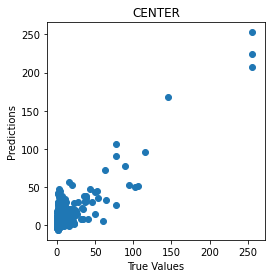

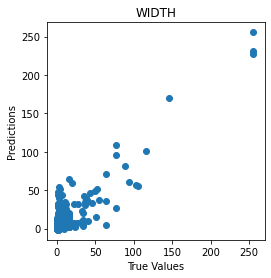

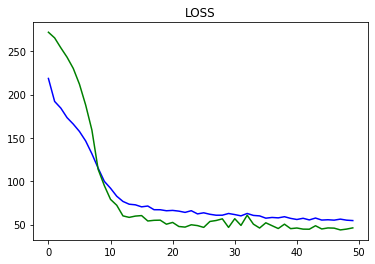

The accuracy of WindowCenter is 82.0%
The accuracy of WindowWidth is 79.0%
Mean absolute error of WindowCenter is 2.1500000953674316
Mean absolute error of WindowWidth is 2.2300000190734863
Mean squared error of WindowCenter is 17.229999542236328, RMSE: 4.150000095367432
Mean squared errory of WindowWidth is 18.489999771118164, RMSE: 4.300000190734863


In [87]:
# Run predict
#Y_pred = mo_model.predict(x_test)
Y_pred = mo_model.predict(image_scaler(x_test_img))
center_pred = Y_pred[0]
width_pred = Y_pred[1]

test_center = y_test[0]
test_width = y_test[1]

# Difference between true and predicted values
plot_diff(test_center, center_pred, title='CENTER')
plot_diff(test_width, width_pred, title='WIDTH')

# Plot MSE
plot_metrics(mo_history, metric_name='loss', title='LOSS')

mo_score_center = r2_score(test_center, center_pred.reshape(-1))
print("The accuracy of WindowCenter is {}%".format(round(mo_score_center, 2) *100))
mo_score_width = r2_score(test_width, width_pred.reshape(-1))
print("The accuracy of WindowWidth is {}%".format(round(mo_score_width, 2) *100))

mo_mae_center =  mean_absolute_error(test_center, center_pred.reshape(-1))
print("Mean absolute error of WindowCenter is {}".format(round(mo_mae_center, 2)))
mo_mae_width =  mean_absolute_error(test_width, width_pred.reshape(-1))
print("Mean absolute error of WindowWidth is {}".format(round(mo_mae_width, 2)))

mo_mse_center = mean_squared_error(test_center, center_pred.reshape(-1))
print("Mean squared error of WindowCenter is {}, RMSE: {}".format(round(mo_mse_center, 2), round(np.sqrt(mo_mse_center), 2)))
mo_mse_width = mean_squared_error(test_width, width_pred.reshape(-1))
print("Mean squared errory of WindowWidth is {}, RMSE: {}".format(round(mo_mse_width, 2), round(np.sqrt(mo_mse_width), 2)))

In [40]:
mo_predictions = pd.DataFrame({'Actual WindowCenter': test_center, 
                            'Predicted WindowCenter': center_pred.reshape(-1),
                            'WindowCenter Difference' : center_pred.reshape(-1) - test_center,
                            'Actual WindowWidth': test_width, 
                            'Predicted WindowWidth': width_pred.reshape(-1),
                            'WindowWidth Difference' : width_pred.reshape(-1) - test_width})
mo_predictions

,Actual WindowCenter,Predicted WindowCenter,WindowCenter Difference,Actual WindowWidth,Predicted WindowWidth,WindowWidth Difference
0,0.272378,1.474107,1.201730,0.311284,3.423756,3.112472
1,0.000000,1.843021,1.843021,4.669261,2.914891,-1.754369
2,3.501999,1.090824,-2.411175,5.836576,2.789129,-3.047447
3,0.451369,1.619665,1.168297,0.455253,2.459007,2.003754
4,4.147923,4.052499,-0.095424,6.295720,4.339745,-1.955975
...,...,...,...,...,...,...
4940,4.801630,0.893057,-3.908573,11.727626,2.213824,-9.513802
4941,2.801599,4.564062,1.762463,3.171206,4.597924,1.426718
4942,15.175329,13.111746,-2.063583,8.560311,8.062113,-0.498199
4943,0.350200,0.695065,0.344865,1.225681,3.692076,2.466395


In [93]:
#Save model
mo_model.save('./mo_model_02/', save_format='tf')

INFO:tensorflow:Assets written to: ./mo_model_02/assets


# Multi Input Model

In [88]:
regularization_factor = 0.01

layer_1 = 32
layer_2 = 64
layer_3 = 128
layer_4 = 128
layer_5 = 256

dense_1 = '64'
dense_2 = '128'


def build_mi_model():
    input_img = Input(shape=(128, 128, 1))

    #input_hbit = Input(shape=(3,))
    #input_mod = Input(shape=(5,))
    #input_bpe = Input(shape=(27,))

    input_metadata = Input(shape=(35,))
    

    x = Conv2D(layer_1, 3, kernel_regularizer=L2(regularization_factor), activation='relu') (input_img)
    x = MaxPooling2D() (x)  

    x = Conv2D(layer_2, 3, kernel_regularizer=L2(regularization_factor), activation='relu') (x)
    x = MaxPooling2D() (x)    
    
    x = Conv2D(layer_3, 3, kernel_regularizer=L2(regularization_factor), activation='relu') (x)
    x = MaxPooling2D() (x)
    
    x = Conv2D(layer_4, 3, kernel_regularizer=L2(regularization_factor), activation='relu') (x)
    x = MaxPooling2D() (x)
    
    x = Conv2D(layer_5, 3, kernel_regularizer=L2(regularization_factor), activation='relu') (x)
    x = MaxPooling2D() (x)
    

    #metadata = keras.layers.concatenate([input_hbit, input_mod, input_bpe])

    
    metadata = Dense(units='32', activation='relu', kernel_regularizer=L2(regularization_factor)) (input_metadata)  #32
    metadata = Dense(units='64', activation='relu', kernel_regularizer=L2(regularization_factor)) (metadata)  #64
    metadata = Dense(units='128', activation='relu', kernel_regularizer=L2(regularization_factor)) (metadata) #128
    metadata = Dense(units='256', activation='relu', kernel_regularizer=L2(regularization_factor)) (metadata) #256
        
    x = Flatten() (x)

    combined = keras.layers.concatenate([x, metadata])
               
    x = Dense(units=dense_1, activation='relu', kernel_regularizer=L2(regularization_factor)) (combined)  
               
    output1 = Dense(units='1', activation='linear', name="window_center")(x)
    output2 = Dense(units='1', activation='linear', name="window_width")(x)
    
    #model = Model(inputs=[input_img, input_hbit, input_mod, input_bpe], outputs=[output1, output2])
    model = Model(inputs=[input_img, input_metadata], outputs=[output1, output2])
    
    return model

mi_model = build_mi_model()

# Specify the optimizer, and compile the model with loss functions for both outputs
loss1 = keras.losses.MeanSquaredError()
loss2 = keras.losses.MeanSquaredError()
losses = {
    "window_center": loss1,
    "window_width": loss2,
}

metric1 = tf.keras.metrics.MeanSquaredError()
metric2 = tf.keras.metrics.MeanSquaredError()
metrics = {
    "window_center": metric1,
    "window_width": metric2,
}

optim = keras.optimizers.Adam(learning_rate=0.0001)

mi_model.compile(optimizer=optim, loss=losses, metrics=metrics)

In [390]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint('mi_model/', save_best_only=True)

In [89]:
#mi_history = mi_model.fit(x=[image_scaler(x_train_img), x_train_hbit, x_train_mod, x_train_bpe], y = y_train, batch_size=256, epochs=50, 
#                          validation_data=([image_scaler(x_val_img), x_val_hbit, x_val_mod, x_val_bpe], y_val), verbose=0)

mi_history = mi_model.fit(x=[image_scaler(x_train_img), x_train_metadata], y = y_train, batch_size=256, epochs=50,validation_data=([image_scaler(x_val_img), x_val_metadata], y_val), verbose=0)

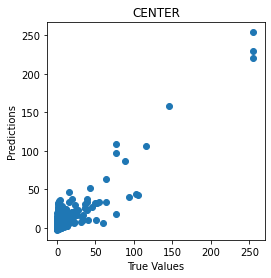

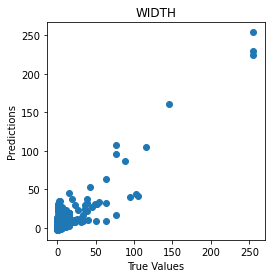

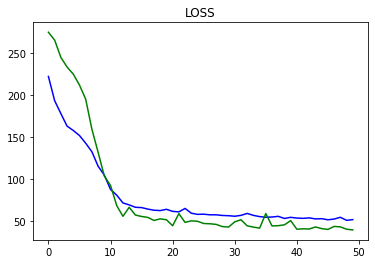

In [90]:
# Run predict
#Y_pred = mi_model.predict([image_scaler(x_test_img), x_test_hbit, x_test_mod, x_test_bpe])
Y_pred = mi_model.predict([image_scaler(x_test_img), x_test_metadata])
center_pred = Y_pred[0]
width_pred = Y_pred[1]

test_center = y_test[0]
test_width = y_test[1]

# Difference between true and predicted values
plot_diff(test_center, center_pred, title='CENTER')
plot_diff(test_width, width_pred, title='WIDTH')

# Plot Loss
plot_metrics(mi_history, metric_name='loss', title='LOSS')

In [91]:
mi_score_center = r2_score(test_center, center_pred.reshape(-1))
print("The accuracy of WindowCenter is {}%".format(round(mi_score_center, 2) *100))
mi_score_width = r2_score(test_width, width_pred.reshape(-1))
print("The accuracy of WindowWidth is {}%".format(round(mi_score_width, 2) *100))

mi_mae_center =  mean_absolute_error(test_center, center_pred.reshape(-1))
print("Mean absolute error of WindowCenter is {}".format(round(mi_mae_center, 2)))
mi_mae_width =  mean_absolute_error(test_width, width_pred.reshape(-1))
print("Mean absolute error of WindowWidth is {}".format(round(mi_mae_width, 2)))

mi_mse_center = mean_squared_error(test_center, center_pred.reshape(-1))
print("Mean squared error of WindowCenter is {}, RMSE: {}".format(round(mi_mse_center, 2), round(np.sqrt(mi_mse_center), 2)))
mi_mse_width = mean_squared_error(test_width, width_pred.reshape(-1))
print("Mean squared errory of WindowWidth is {}, RMSE: {}".format(round(mi_mse_width, 2), round(np.sqrt(mi_mse_width), 2)))

The accuracy of WindowCenter is 88.0%
The accuracy of WindowWidth is 83.0%
Mean absolute error of WindowCenter is 1.4600000381469727
Mean absolute error of WindowWidth is 1.8700000047683716
Mean squared error of WindowCenter is 11.710000038146973, RMSE: 3.4200000762939453
Mean squared errory of WindowWidth is 14.779999732971191, RMSE: 3.8399999141693115


In [92]:
#Save model
mi_model.save('./mi_model_02/', save_format='tf')

INFO:tensorflow:Assets written to: ./mi_model_02/assets
